# Simulating and AFM Cantilever response in Python

The simulation code integrates the ordinary differential equation describing an AFM cantilever's motion. That, by itself, is not particularly interesting as it's just an exercise for undergraduates in physics courses. What IS interesting, is adding some sort of transient excitation and seeing the response.

The simulation code in **FFTA** package allows for an excitation voltage to be applied at some particular point in time and therefore affects the cantilever's motion. More specifically, this simulation applies a shift in the resonance frequenecy with some time constant and an electrostatic force that changes with the same time constant. By default, that time-dependent response is an exponential decay (1-exp(-t/tau)), but that can be any callable function.

A secondary option is to apply an electric drive to the cantilever to see second resonance responses, but that is outside the scope of this notebook.

Much of this is used in the following publication:
Karatay DU, Harrison JA, et al. Fast time-resolved electrostatic force microscopy: Achieving sub-cycle time resolution. *Rev Sci Inst.* **87,** 053702 (2016). [DOI: 10.1063/1.4948396](http://dx.doi.org/10.1063/1.4948396)

In [28]:
!pip install FFTA==0.2

In [0]:
import ffta
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np

from ffta.simulation.mechanical_drive import MechanicalDrive
from ffta.simulation.load import simulation_configuration
from ffta.simulation import excitation

In [44]:
# Specify our configuration file
# In this case, we'll download our shared file and use that. This block works for CoLab; for Jupyter, download from the URL then set path manually
!pip install wget
import wget
path = r'example_sim_params.cfg'
wget.download('https://raw.githubusercontent.com/rajgiriUW/ffta/master/ffta/simulation/example_sim_params_roundnumbers.cfg', path, bar=None)

path = r'/content/example_sim_params.cfg'
print(path)

/content/example_sim_params.cfg


## The configuration file

The configuration if usually some .cfg file on the disk. Typically it has a form like this:

```
[Cantilever Parameters]
amp_invols = 5.52e-08       ;in m/V.
def_invols = 5.06e-08       ;in m/V.
soft_amp = 0.3              ;in m/V
drive_freq = 272244.5       ;in Hz.
res_freq = 272218.4         ;in m.
k = 26.2                    ;in N/m.
q_factor = 432

[Force Parameters]
es_force = 4e-9             ;in N.
delta_freq = -170           ;in Hz.
tau = 10e-9                 ;in seconds.

[Simulation Parameters]
trigger = 16384e-7          ;in seconds.
total_time = 32768e-7       ;in seconds.
sampling_rate = 1e7         ;in Hz.
```

Other possible parameters for the Force are 
* dC/dz (a typical value of 1e-10 F/m is fine
* V_cpd, V_dc, V_ac : voltages that describe the electric drive signal

Currently there's no way to simply supply a drive signal as might be recorded in an experiment, but that will be added

Let's go through what some of these parameters mean:

```
amp_invols: 
    Amplitude inverted optical lever sensitivity, converts amplitude from Volts to meters
def_invols: 
    Defletion inverted optical level sensitivity, converts the deflection from Volts to meters.

soft_amp: 
    "Soft amplitude" which is just an archaic way of saying cantilever amplitude during EFM
drive_freq and res_freq: 
    The driving frequency and resonance frequency of the cantilever
k: 
    spring constant
q_factor: 
    Quality factor of the cantilever (i.e. FWHM of the tune curve peak

es_force: 
    Electrostatic force. This value is measured experimentally by applying a voltage and measuring the deflection (using Hooke's Law F = -kz)
delta_freq: 
    When shifting the resonance frequency, this is how much to shift it by
tau: 
    time constant for the exponential function applied to the cantilever.

trigger: 
    When during the simulation to apply a change in the resonance frequency
total_time: 
    Total time to integrate for
sampling_rate: 
    This is only used to have the simulation match the experiment. The experiment is often at 1e7 Hz (10 MHz). The simulation is currently hard-coded at 100 MHz then down-sampled at the end.
```

##### What does that mean?

In our simulation the resonance frequency is changed at some point in time. In the config file this is "trigger_time" and the total length of the simulation is "total_time." So, for a cantilever where **total_time** = 1 ms, and **trigger** = 0.5 ms, then at 0.5 ms the resonance frequency is shifted by an amount **delta_freq**, with the rate of the shift controlled by **tau**

#### The next step is load the configuration file

This next line creates three dictionaries corresponding to the three sections above. 

In [0]:
can_params, force_params, sim_params = simulation_configuration(path)

In [47]:
print('Force parameters are', force_params)

Force parameters are {'es_force': 3e-09, 'delta_freq': -200.0, 'tau': 1e-05}


## Create the cantilever object
---------------
The simulation uses a base class, Cantilever, and we call Cantilever using parent classes that actually do the interesting parts of the simulation.

In the next cell, we create the Cantilever object using a class MechanicalDrive.
```
cant = ffta.simulation.mechanical_drive.MechanicalDrive(can_params, force_params, sim_params)
```

This creates "cant" which is an object of the class "MechanicalDrive," which is itself inheriting Cantilever. Note that you could be a little more readable and say:

```
params = ffta.simulation.load.simulation_configuration(path)
cant =  ffta.simulation.mechanical_drive.MechanicalDrive(*params)
```

...but that's a style choice.

Anyway, now that we have our MechanicalDrive object, we can simulate it.

In [0]:
cant = MechanicalDrive(can_params, force_params, sim_params)

## Properties of our cantilever

The object "cant" here contains many parameters, for which you may want to check out the source code.

To see some relevant things, you could type for example:
```
cant.tau
cant.trigger
cant.total_time
cant.drive_freq
cant.res_freq
```
In Python, these are all stored in a dictionary called .__dict__ that you rarely need to access.

Of these, "tau" is the time constant assuming a single exponential.

In [50]:
# Here is a list of ALL the parameters when you initialize the object
for k, v in cant.__dict__.items():
  print(k, v)

amp_invols 5e-08
def_invols 5e-08
soft_amp 1.0
drive_freq 300000.0
res_freq 300000.0
k 20.0
q_factor 450.0
w0 1884955.5921538759
wd 1884955.5921538759
beta 2094.3951023931954
mass 5.628954646796543e-12
amp 5e-08
f0 394.7841760435743
delta 1.5707963267948966
es_force 3e-09
delta_freq -200.0
tau 1e-05
delta_w -1256.6370614359173
fe 532.9586376588254
trigger 0.0002
total_time 0.005
sampling_rate 10000000.0
t_Z [0.00000e+00 1.00002e-07 2.00004e-07 ... 4.99980e-03 4.99990e-03
 5.00000e-03]
freq_Z [0.0000e+00 2.0000e+02 4.0000e+02 ... 4.9996e+06 4.9998e+06 5.0000e+06]
fit_params {'filter_amplitude': True, 'method': 'hilbert', 'fit': True, 'fit_form': 'product'}
parameters {'es_force': 3e-09, 'delta_freq': -200.0, 'tau': 1e-05, 'trigger': 0.0002, 'total_time': 0.005, 'sampling_rate': 10000000.0, 'bandpass_filter': 1.0, 'drive_freq': 300000.0, 'filter_bandwidth': 10000.0, 'n_taps': 799, 'roi': 0.0003, 'window': 'blackman', 'wavelet_analysis': 0}
can_params {'amp_invols': 5e-08, 'def_invols': 5

## Simulate the cantilever

The simulation can take one of two parameters:

```
trigger_phase: float, optional
    Trigger phase is in degrees and with respect to cosine. Default value is 180.
Z0 : list, optional
    Z0 = [z0, v0], the initial position and velocity
    If not specified, is calculated from the analytical solution to DDHO (using class function "set_conditions")
```

**Trigger_phase** controls the phase of the cantilever when the excitation is applied. In our paper on this subject, we found that the phase does matter; if the cantilever is at some random phase relative to the excitation, you can lose time-resolution. Practically speaking, this effect is not all that important except at very fast timescales. 

The cantilever, prior to ODE integration, will try and set the initial conditions for the differential equation. That is, it will try and set Z(0) and v(0), the initial position and velocity for time t=0. The default is to set them such that the cantilever is at steady-state conditions for t=0, avoiding any wasted simulation time.

**Z0** Instead of defaulting, you can set the initial conditions explicitly. This parameter is useful for electrically-driven cantilevers where the solution to the DDHO is not well known.

In [0]:
# Run the simulation!
Z, info = cant.simulate()

### Plot the results

Now that we have our simulation, let's see what it looks like. Note that Z is rescaled to Volts to match an experiment, but you can multiply by *cant.def_invols*

Text(0.5, 1.0, 'Simulation with time constant = 1e-05 s')

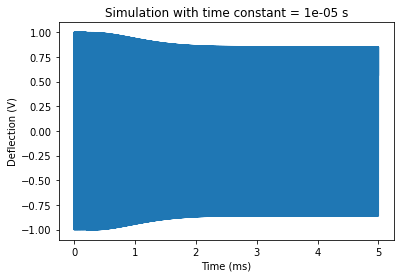

In [52]:
plt.plot(cant.t_Z * 1e3, Z)
plt.xlabel('Time (ms)')
plt.ylabel('Deflection (V)')
plt.title('Simulation with time constant = ' + str(cant.tau) + ' s')

As you can see, the cantilever is going well, then at halfway there's a change due to an exponential voltage pulse with time constant 10 ns. Let's see what happens if we change the initial conditions.

Text(0.5, 1.0, 'Simulation with initial conditions 0 m, 0 m/s')

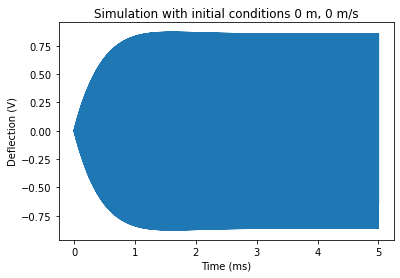

In [53]:
Z, info = cant.simulate(Z0 = [0,0])
plt.plot(cant.t_Z * 1e3, Z)
plt.xlabel('Time (ms)')
plt.ylabel('Deflection (V)')
plt.title('Simulation with initial conditions 0 m, 0 m/s')

##### What happened? 
Well, because we specified the cantilever to be at rest at time t=0 (Z0 = [0,0]), the cantilever had to oscillate for awhile before it settled at its steady-state condition. This initial part of the simulation is not all that useful, and it just wastes time, so we set the initial conditions. 



### Change Parameters for the Simulation

Now, what if we change up some of the parameters? Let's try a different time constant, maybe of 1e-3 s (1 ms).

```
cant.func_args = [1e-3]
```

In the cantilever, we will call a function that applies a single exponential decay to the voltage. That function requires a parameter, which we supply in the **func_args** list. 

We can use this approach for** bi-exponential **and **stretched exponentials** as well.

Below, we will change the time constant to **1e-8 s**, **1e-4 s**, and **1e-2 s** and see the result

In [0]:
# This is how you might change the time constant
cant.tau = 1e-3

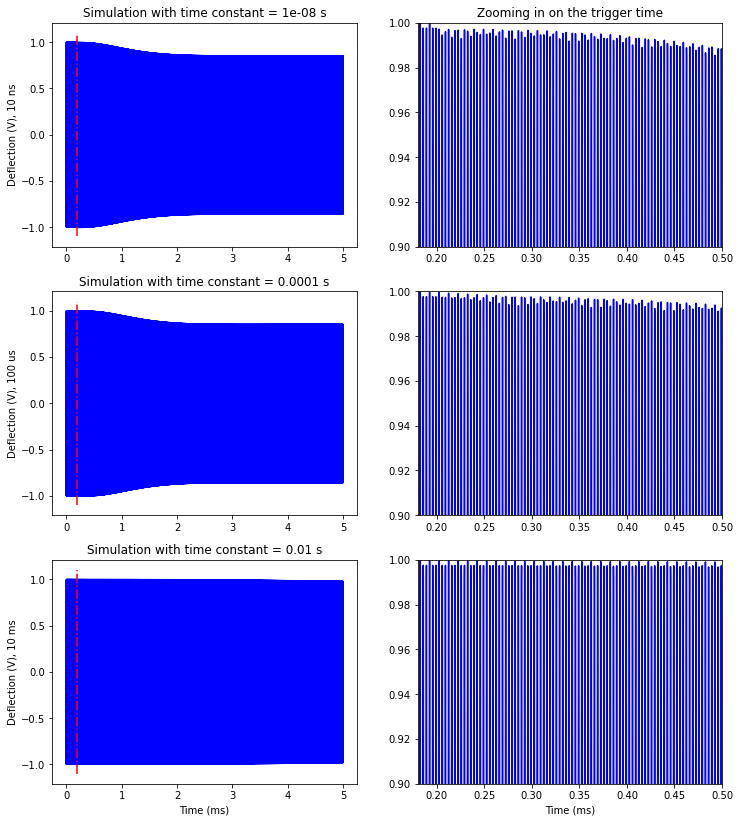

In [62]:
fig, a = plt.subplots(nrows=3, ncols = 2, figsize=(12,14))

cant.tau = 1e-8
cant.func_args = [cant.tau]
Z, info = cant.simulate()
a[0][0].plot(cant.t_Z * 1e3, Z, 'b')
a[0][1].plot(cant.t_Z * 1e3, Z, 'b')
a[0][0].set_ylabel('Deflection (V), 10 ns')
a[0][0].set_title('Simulation with time constant = ' + str(cant.tau) + ' s')
a[0][1].set_title('Zooming in on the trigger time')
a[0][1].set_xlim(0.18, 0.5)
a[0][1].set_ylim(0.9, 1)

cant.tau = 1e-4
cant.func_args = [cant.tau]
Z, info = cant.simulate()
a[1][0].plot(cant.t_Z * 1e3, Z, 'b')
a[1][1].plot(cant.t_Z * 1e3, Z, 'b')
a[1][0].set_ylabel('Deflection (V), 100 us')
a[1][0].set_title('Simulation with time constant = ' + str(cant.tau) + ' s')
a[1][1].set_xlim(0.18, 0.5)
a[1][1].set_ylim(0.9, 1)

cant.tau = 1e-2
cant.func_args = [cant.tau]
Z, info = cant.simulate()
a[2][0].plot(cant.t_Z * 1e3, Z, 'b')
a[2][1].plot(cant.t_Z * 1e3, Z, 'b')
a[2][0].set_ylabel('Deflection (V), 10 ms')
a[2][0].set_title('Simulation with time constant = ' + str(cant.tau) + ' s')
a[2][1].set_xlim(0.18, 0.5)
a[2][1].set_ylim(0.9, 1)

a[2][0].set_xlabel('Time (ms)')
a[2][1].set_xlabel('Time (ms)')

# Add a line to mark the trigger at each point
trigger_line = np.linspace(-1.1, 1.1, 10)
a[0][0].plot(np.ones(len(trigger_line))*cant.trigger * 1e3, trigger_line, 'r-.')
a[1][0].plot(np.ones(len(trigger_line))*cant.trigger * 1e3, trigger_line, 'r-.')
a[2][0].plot(np.ones(len(trigger_line))*cant.trigger * 1e3, trigger_line, 'r-.')

##### What happened? 
Here, we are changing how quickly the resonance frequency changes. In the 10 ns and 100 us case, the cantilever looks similar. However, the key is what's happening at the trigger time. For the 10 ns case, there's a sharp change at the trigger (~1.6 ms). For the 100 us case, it's a slow change. For the 10 ms case, there's barely any change. 

That means the interesting dynamics are in this region of the time window. The cantilevers in all three cases "relax" at about the same rate, because that is just dependent upon the cantilever Q factor for the most part, and it is unrelated to any transient effect. 

Finally, let's try changing the electrostatic force and the delta_freq (the amount of electrostatic force applied, i.e. the voltage, and the amount the resonance frequency shifts by). These values should normally not be changed independently as they're related to one another and are acquired during a measurement. But, just for fun, let's see what happens.

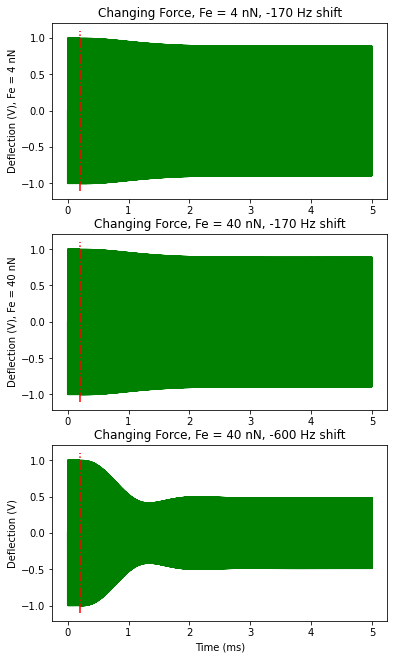

In [64]:
fig, a = plt.subplots(nrows=3, figsize=(6, 11))

cant.tau = 1e-6
cant.func_args = [cant.tau]
cant.es_force = 4e-9 
cant.delta_freq = -170 
cant.delta_w = 2* np.pi * cant.delta_freq # convert to radians
Z, info = cant.simulate()
a[0].plot(cant.t_Z * 1e3, Z, 'g')
a[0].set_ylabel('Deflection (V), Fe = 4 nN')
a[0].set_title('Changing Force, Fe = 4 nN, -170 Hz shift')

cant.es_force = 4e-7 # 100 X the force
cant.delta_freq = -170 # 600 Hz is a huge shift
cant.delta_w = 2* np.pi * cant.delta_freq # convert to radians
Z, info = cant.simulate()
a[1].plot(cant.t_Z * 1e3, Z, 'g')
a[1].set_ylabel('Deflection (V), Fe = 40 nN')
a[1].set_title('Changing Force, Fe = 40 nN, -170 Hz shift')

cant.es_force = 4e-9 
cant.delta_freq = -600 # 600 Hz is a huge shift
cant.delta_w = 2* np.pi * cant.delta_freq # convert to radians
Z, info = cant.simulate()
a[2].plot(cant.t_Z * 1e3, Z, 'g')
a[2].set_ylabel('Deflection (V)')
a[2].set_xlabel('Time (ms)')
a[2].set_title('Changing Force, Fe = 40 nN, -600 Hz shift')

# Add a line to mark the trigger at each point
trigger_line = np.linspace(-1.1, 1.1, 10)
a[0].plot(np.ones(len(trigger_line))*cant.trigger * 1e3, trigger_line, 'r-.')
a[1].plot(np.ones(len(trigger_line))*cant.trigger * 1e3, trigger_line, 'r-.')
a[2].plot(np.ones(len(trigger_line))*cant.trigger * 1e3, trigger_line, 'r-.')

As you can see, the Electrostatic Force alone doesn't do too much. The change in resonance frequency, though, changes a lot! This effect is because the change in resonance frequency changes the factors proportional to z and z' in the DDHO equation.

## Changing the Excitation
---------
We can supply a range of functions and parameters to the MechanicalDrive object to change the parameters of the simulation. 

In the ```excitation.py``` file there are several different excitation functions listed. These are (currently) 
* **single exponential**
* **biexponential (sum)** 
* **stretched exponential**

We can also supply an **arbitrary excitation** as long as it is scaled from *0 to 1*. I'll go through an example of each.

### Single Exponential

This is actually the default case. But, let's go through it explicitly:

```
# Create a cantilever using single exponential change to resonance, 1 ms tau
params = [can_params, force_params, sim_params]
MechanicalDrive(*params, func = excitation.single_exp, func_args=[1e-3])
```

```func``` is any callable function. What this does is apply a change such that omega_0 and Fe (resonance frequency, electrostatic force) are multiplied by this function once the trigger occurs.



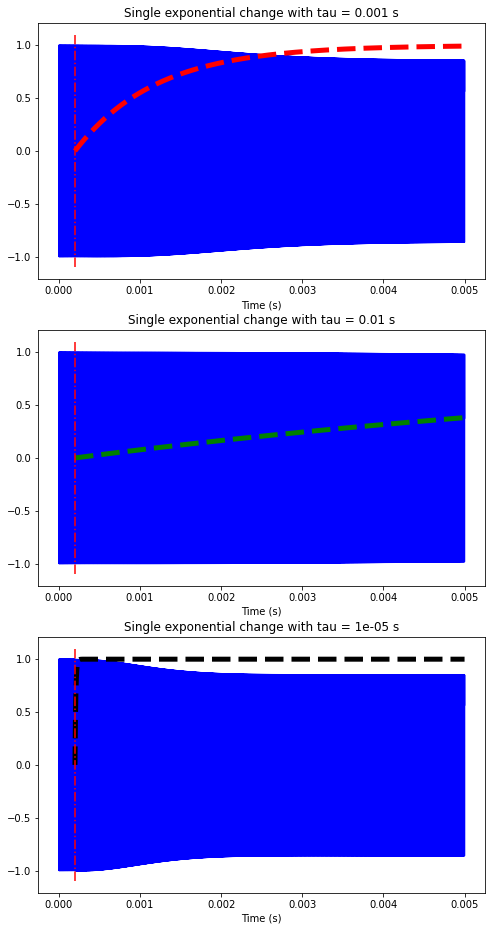

In [69]:
cant = MechanicalDrive(can_params, force_params, sim_params, func=excitation.single_exp, func_args=[1e-3])

time_axis = np.arange(cant.trigger, cant.total_time, 1/cant.sampling_rate)
tau = 1e-3
exc_function = excitation.single_exp(time_axis - cant.trigger, tau)

fig, ax = plt.subplots(nrows=3, figsize=(8,16))

Z, _ = cant.simulate()
ax[0].plot(cant.t_Z, Z, 'b')
ax[0].plot(time_axis, exc_function, 'r--', linewidth=5)
ax[0].set_title('Single exponential change with tau = ' + str(tau) + ' s')
ax[0].set_xlabel('Time (s)')

# Change tau and resimulate
tau = 1e-2
cant.func_args = [tau]
exc_function = excitation.single_exp(time_axis - cant.trigger, tau)

Z, _ = cant.simulate()
ax[1].plot(cant.t_Z, Z, 'b')
ax[1].plot(time_axis, exc_function, 'g--', linewidth=5)
ax[1].set_title('Single exponential change with tau = ' + str(tau) + ' s')
ax[1].set_xlabel('Time (s)')

# Change tau and resimulate
tau = 1e-5
cant.func_args = [tau]
exc_function = excitation.single_exp(time_axis - cant.trigger, tau)

Z, _ = cant.simulate()
ax[2].plot(cant.t_Z, Z, 'b')
ax[2].plot(time_axis, exc_function, 'k--', linewidth=5)
ax[2].set_title('Single exponential change with tau = ' + str(tau) + ' s')
ax[2].set_xlabel('Time (s)')

# Add a line to mark the trigger at each point
trigger_line = np.linspace(-1.1, 1.1, 10)
ax[0].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')
ax[1].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')
ax[2].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')

### Bi-Exponential

These functions are also included in the file ```excitation.py``` and can be easily added. They're called "bi_exp" and "str_exp"

If you already have a cantilever, you need to change two things:
1. ```cant.func ```
2. ```cant.func_args```

You can also change these when calling the function in the first place.

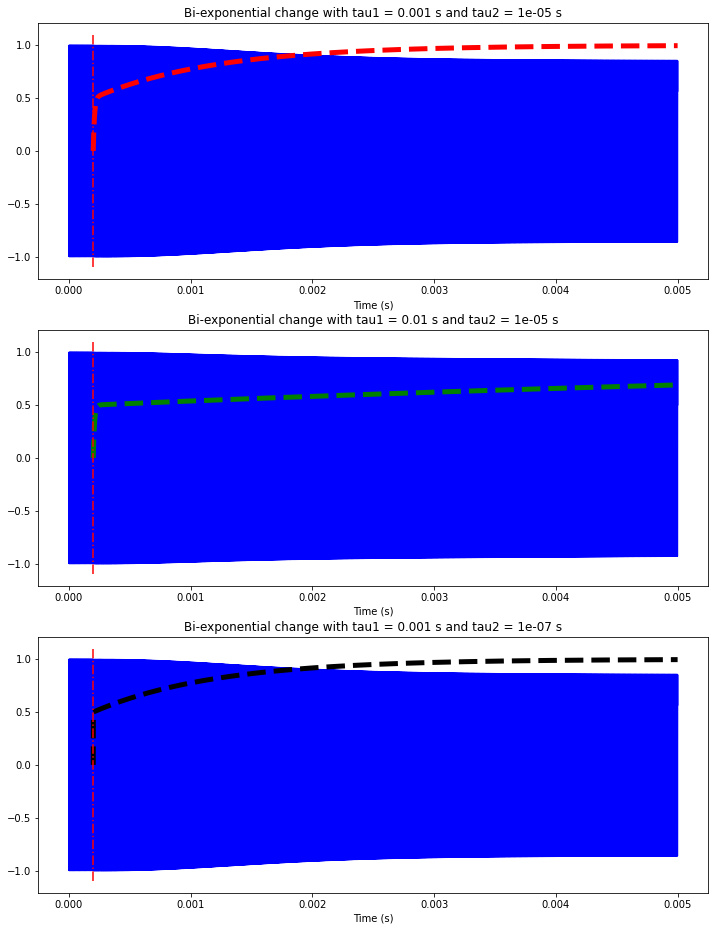

In [70]:
# Bi-exponential with tau1 = 1e-3 and tau2 = 1e-5
cant = MechanicalDrive(can_params, force_params, sim_params, func=excitation.bi_exp, func_args=[1e-3, 1e-5])

time_axis = np.arange(cant.trigger, cant.total_time, 1/cant.sampling_rate)
exc_function = excitation.bi_exp(time_axis - cant.trigger, *cant.func_args)

fig, ax = plt.subplots(nrows=3, figsize=(12,16))

Z, _ = cant.simulate()
ax[0].plot(cant.t_Z, Z, 'b')
ax[0].plot(time_axis, exc_function, 'r--', linewidth=5)
ax[0].set_title('Bi-exponential change with tau1 = ' + str(cant.func_args[0]) + ' s and tau2 = ' + str(cant.func_args[1]) + ' s')
ax[0].set_xlabel('Time (s)')

# Change tau1 to 1e-2
cant.func_args = [1e-2, 1e-5]
exc_function = excitation.bi_exp(time_axis - cant.trigger, *cant.func_args)

Z, _ = cant.simulate()
ax[1].plot(cant.t_Z, Z, 'b')
ax[1].plot(time_axis, exc_function, 'g--', linewidth=5)
ax[1].set_title('Bi-exponential change with tau1 = ' + str(cant.func_args[0]) + ' s and tau2 = ' + str(cant.func_args[1]) + ' s')
ax[1].set_xlabel('Time (s)')

# Change tau2 to 1e-7 and tau1 to 1e-3
cant.func_args = [1e-3, 1e-7]
exc_function = excitation.bi_exp(time_axis - cant.trigger, *cant.func_args)

Z, _ = cant.simulate()
ax[2].plot(cant.t_Z, Z, 'b')
ax[2].plot(time_axis, exc_function, 'k--', linewidth=5)
ax[2].set_title('Bi-exponential change with tau1 = ' + str(cant.func_args[0]) + ' s and tau2 = ' + str(cant.func_args[1]) + ' s')
ax[2].set_xlabel('Time (s)')

# Add a line to mark the trigger at each point
trigger_line = np.linspace(-1.1, 1.1, 10)
ax[0].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')
ax[1].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')
ax[2].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')

### Stretched Exponential 

This can be modified in the same way, except that now:

```cant.func_args = [tau, beta]```

You can also change these when calling the function in the first place, like above.

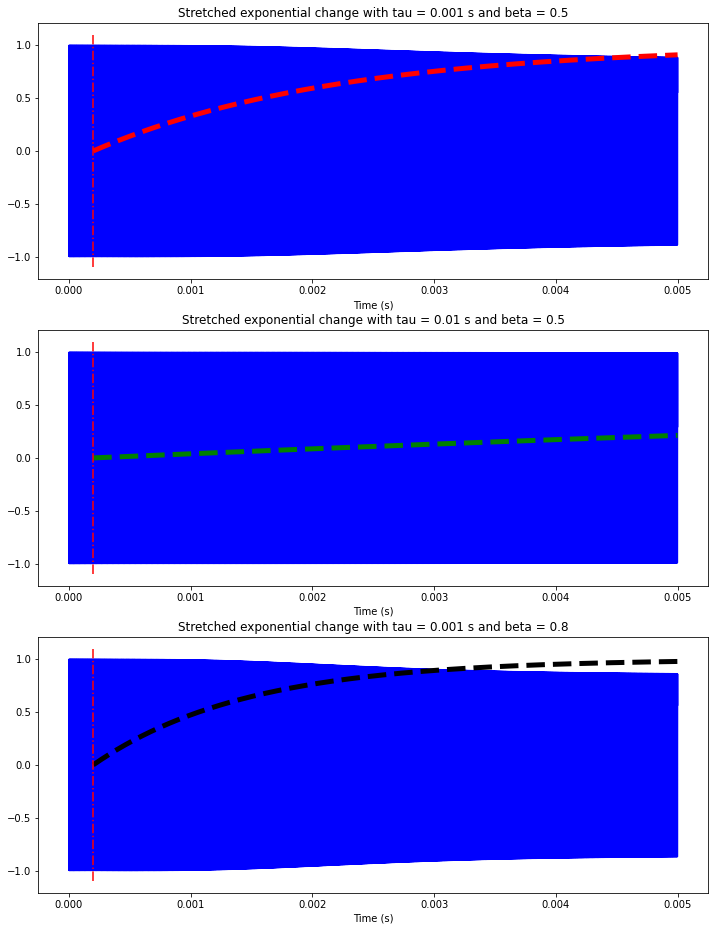

In [71]:
# Stretched exponential with tau = 1e-3 and beta=0.5
cant = MechanicalDrive(can_params, force_params, sim_params, func=excitation.str_exp, func_args=[1e-3, 0.5])

time_axis = np.arange(cant.trigger, cant.total_time, 1/cant.sampling_rate)
exc_function = excitation.str_exp(time_axis - cant.trigger, *cant.func_args)

fig, ax = plt.subplots(nrows=3, figsize=(12,16))

Z, _ = cant.simulate()
ax[0].plot(cant.t_Z, Z, 'b')
ax[0].plot(time_axis, exc_function, 'r--', linewidth=5)
ax[0].set_title('Stretched exponential change with tau = ' + str(cant.func_args[0]) + ' s and beta = ' + str(cant.func_args[1]))
ax[0].set_xlabel('Time (s)')

# Change tau to 1e-5, keep beta the same
cant.func_args = [1e-2, 0.5]
exc_function = excitation.str_exp(time_axis - cant.trigger, *cant.func_args)

Z, _ = cant.simulate()
ax[1].plot(cant.t_Z, Z, 'b')
ax[1].plot(time_axis, exc_function, 'g--', linewidth=5)
ax[1].set_title('Stretched exponential change with tau = ' + str(cant.func_args[0]) + ' s and beta = ' + str(cant.func_args[1]))
ax[1].set_xlabel('Time (s)')

# Change tau back to 1e-3, make beta 0.85
cant.func_args = [1e-3, 0.8]
exc_function = excitation.str_exp(time_axis - cant.trigger, *cant.func_args)

Z, _ = cant.simulate()
ax[2].plot(cant.t_Z, Z, 'b')
ax[2].plot(time_axis, exc_function, 'k--', linewidth=5)
ax[2].set_title('Stretched exponential change with tau = ' + str(cant.func_args[0]) + ' s and beta = ' + str(cant.func_args[1]))
ax[2].set_xlabel('Time (s)')

# Add a line to mark the trigger at each point
trigger_line = np.linspace(-1.1, 1.1, 10)
ax[0].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')
ax[1].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')
ax[2].plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')

### Arbitrary Function

You can easily supply an arbitrary function, as long as you provide the relevant parameters.

```
def new_function(t, tau, tau2, tau3):
    return t * tau1 + t * tau2**2 - tau3

cant = MechanicalDrive(*params, func=new_function, func_args=[tau, tau2, tau3])
```

You can also directly change these after the ```cant``` object exists:

```
cant.func = new_functon
cant.func_args = [tau, tau2, tau3]
```

Note that the function ***should scale from 0 to 1*** to work.

Let's try a quick example with a linear ramp.

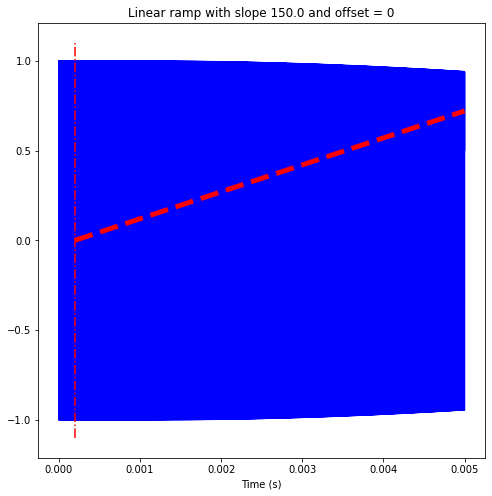

In [96]:
def linear_ramp(t, slope, yoffset):
  
  return slope*t + yoffset

cant = MechanicalDrive(can_params, force_params, sim_params, func=linear_ramp, func_args=[1.5e2, 0])

time_axis = np.arange(cant.trigger, cant.total_time, 1/cant.sampling_rate)
exc_function = linear_ramp(time_axis - cant.trigger, *cant.func_args)

fig, ax = plt.subplots(figsize=(8, 8))

Z, _ = cant.simulate()
ax.plot(cant.t_Z, Z, 'b')
ax.plot(time_axis, exc_function, 'r--', linewidth=5)
ax.set_title('Linear ramp with slope ' + str(cant.func_args[0]) + ' and offset = ' + str(cant.func_args[1]))
ax.set_xlabel('Time (s)')

# Add a line to mark the trigger at each point
trigger_line = np.linspace(-1.1, 1.1, 10)
ax.plot(np.ones(len(trigger_line))*cant.trigger, trigger_line, 'r-.')



### Arbitrary Array

Lastly, you can also just directly supply the scaling yourself. This is passed differently, using parameter ```v_array```

```v_array``` must be the **same sampling rate and length** as the time axis you are simulating over.

This process requires a little thought. You could create a simple numpy array that's the length you want if you know the parameters ```total_time``` and ```sampling_rate```. If you multiply a time by a sampling_rate, you get an index of an array.

{'trigger': 0.0002, 'total_time': 0.005, 'sampling_rate': 10000000.0}


Text(0.5, 0, 'Time (s)')

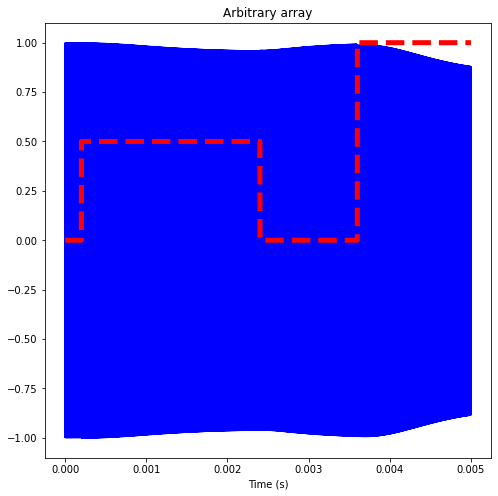

In [97]:
# Supply an arbitrary voltage array that effectively turns off the drive_frequency
print(sim_params)
arb_array = np.zeros(int(sim_params['sampling_rate']*sim_params['total_time']))
trigger_index = int(sim_params['trigger'] * sim_params['sampling_rate'])
half_index = int(0.5* (sim_params['total_time'] - sim_params['trigger']) * sim_params['sampling_rate'])
threefourths_index = int(0.75* (sim_params['total_time'] - sim_params['trigger']) * sim_params['sampling_rate'])
arb_array[trigger_index:half_index] = 0.5
arb_array[half_index:threefourths_index] = 0
arb_array[threefourths_index:] = 1

cant = MechanicalDrive(can_params, force_params, sim_params, v_array=arb_array)
time_axis = np.arange(0, cant.total_time, 1/cant.sampling_rate)
fig, ax = plt.subplots(figsize=(8, 8))

Z, _ = cant.simulate()
ax.plot(cant.t_Z, Z, 'b')
ax.plot(time_axis, arb_array, 'r--', linewidth=5)
ax.set_title('Arbitrary array')
ax.set_xlabel('Time (s)')